# Analyse function similarity between IUPRED3 and AlphaFold pLDDT
Select 1000 random structures, get their pLDDT and IUPRED3 scores and calculate Spearman's r

In [1]:
import glob
import gzip
import re
import requests

import pandas as pd
import numpy as np

from pqdm.threads import pqdm
from bin.iupred3.iupred3_lib import iupred
from scipy.stats import spearmanr

In [2]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df = pd.concat(dfs)

In [8]:
random_uniprot_ids = df.loc[(df['seq_len'] > 20) & (df['proteome'] != 'HUMAN')][['uniprot_id', 'proteome']].sample(n=5000).values

In [9]:
def get_plddt_scores(uniprot_id: str, proteome: str):
    pLDDT_scores = []
    with gzip.open(glob.glob(f'../data/alphafold/v2/*_{proteome}_v2/AF-{uniprot_id}-*.pdb.gz')[0], "rt") as handle:
        seen_res_i = 0
        for line in handle:
            # The pLDDT is the last number in each ATOM line
            if line.startswith('ATOM'):
                res_i = int(line[22:27])
                if res_i != seen_res_i:
                    seen_res_i = res_i
                    pLDDT = float(line[-20:-13])
                    pLDDT_scores.append(pLDDT)
    return np.asarray(pLDDT_scores)


def load_sequence_from_uniprot(uniprot_id: str) -> str:
    res = ''
    try:
        response = requests.get(f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta").text
        for decoded in response.split('\n'):
            if not decoded.startswith('>'):
                res += decoded
    except Exception as e:
        print(f'Failed fetching sequence: {e.message if hasattr(e, "message") else e}')
        pass
    return res


def get_iupred_scores(uniprot_id: str):
    seq = load_sequence_from_uniprot(uniprot_id)
    if seq is None:
        return None
    try:
        res = iupred(seq, 'long')
        return res[0]
    except:
        print(f'Error in {seq}')


def calculate_spearman(entry):
    try:
        plddts = get_plddt_scores(entry[0], entry[1])
        iupreds = get_iupred_scores(entry[0])
        rho, p = spearmanr(plddts, iupreds)
        return rho
    except:
        print(f'Error in {entry[0]}')
        return None

In [3]:
rhos = pqdm(random_uniprot_ids, calculate_spearman, n_jobs=10, desc='Sequences')

In [20]:
df_spearman = df[df['iupred_plddt_spearman'].notnull()].copy()
df_spearman['iupred_auc_normalized'] = df_spearman['iupred_auc'] / df_spearman['seq_len']
df_spearman.describe()

,seq_len,domain_count,max_pae,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,repeat_6mers,non_repeat_6mers,repeat_6mers_100,non_repeat_6mers_100,iupred_plddt_spearman,iupred_auc_normalized
count,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000,513491.000000
mean,418.879011,0.570520,30.831542,33.827475,75.295734,79.046136,0.356741,126.058216,0.516297,0.000656,0.584466,0.019510,-0.311983,0.287498
std,343.376647,1.107859,1.480995,11.474122,15.024180,18.828361,0.292590,147.567754,4.490001,0.048519,4.744459,0.390805,0.317159,0.175203
min,20.000000,0.000000,6.000000,1.390000,23.077300,22.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.987435,0.000000
25%,184.000000,0.000000,30.900000,25.650000,64.819100,64.350000,0.112000,37.979450,0.000000,0.000000,0.000000,0.000000,-0.564031,0.162901
50%,330.000000,0.000000,31.300000,31.230000,77.945700,87.310000,0.274000,79.952200,0.000000,0.000000,0.000000,0.000000,-0.345583,0.255789
75%,534.000000,1.000000,31.400000,38.710000,87.670100,94.025000,0.556400,156.599100,0.000000,0.000000,0.000000,0.000000,-0.103957,0.387481
max,2699.000000,46.000000,31.700000,97.030000,98.724100,98.860000,1.000000,2730.699900,342.000000,11.000000,382.000000,83.000000,0.918797,7.224074


In [38]:
import matplotlib.pyplot as plt

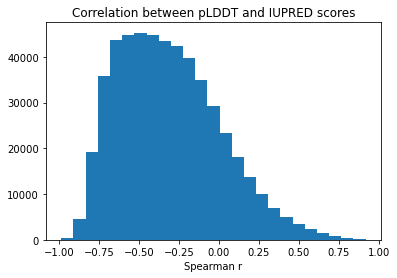

In [6]:
%matplotlib inline
fig, ax = plt.subplots()
ax.hist(df_spearman['iupred_plddt_spearman'].values, bins=25)
ax.set_title('Correlation between pLDDT and IUPRED scores')
ax.set_xlabel('Spearman r')
plt.show()

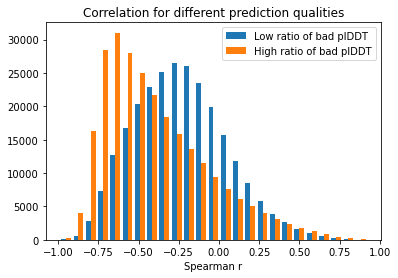

In [45]:
%matplotlib inline
fig, ax = plt.subplots()

median = df_spearman['ratio_bad_plddt'].median()
good_values = df_spearman[df_spearman['ratio_bad_plddt'] <= median]['iupred_plddt_spearman'].values
bad_values = df_spearman[df_spearman['ratio_bad_plddt'] > median]['iupred_plddt_spearman'].values

ax.hist([good_values, bad_values], bins=25, label=['Low ratio of bad plDDT', 'High ratio of bad plDDT'])
ax.set_title('Correlation for different prediction qualities')
ax.set_xlabel('Spearman r')

plt.legend()
plt.show()

You can definitely see a significant correlation between both scores for most of the sequences. As expected, a low pLDDT often means high IUPRED score. However, we also see that there are outliers where a low pLDDT correlates with a low IUPRED. This might be connected to the sequences we found earlier with a high ratio of bad pLDDTs and a low IUPRED AUC. Vikram found those to be disordered and we expect IUPRED to be bad for those.

- Count repeat 5 instead 4
- Cut out -0.3 to 0.3 and throw uniprot id into KEGG (https://www.genome.jp/kegg/pathway.html) and GO databases (enrichment in signalling?)

In [32]:
df_spearman.nsmallest(10, columns=['iupred_plddt_spearman'])[['iupred_plddt_spearman', 'iupred_auc_normalized']].mean()

iupred_plddt_spearman   -0.971244
iupred_auc_normalized    0.160105
dtype: float64

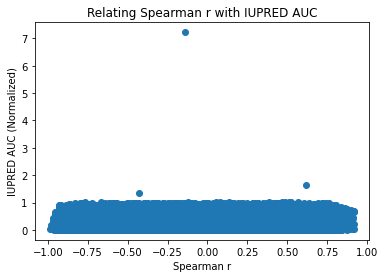

In [22]:
%matplotlib inline
fig, ax = plt.subplots()
ax.scatter(df_spearman['iupred_plddt_spearman'].values, df_spearman['iupred_auc_normalized'].values)
ax.set_title('Relating Spearman r with IUPRED AUC')
ax.set_xlabel('Spearman r')
ax.set_ylabel('IUPRED AUC (Normalized)')
plt.show()